# Deep Learning - Exercise 3

### What We'll Cover Today:
* 🎯 Convolutional Neural Networks basics
* 📊 Working with CIFAR-10 dataset
* ✅ Model validation techniques 
* 🔄 Batch normalization in Keras

### Dataset Focus: CIFAR-10 
* 60,000 32x32 color images
* 10 different classes
* Standard computer vision benchmark

### Key Concepts:
* Model validation importance
* Batch normalization benefits
* CNN architecture basics

[Open in Google colab](https://colab.research.google.com/github/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_03.ipynb)
[Download from Github](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_03.ipynb)

##### Remember to set **GPU** runtime in Colab!

In [41]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import tensorflow as tf
import tensorflow.keras as keras
import requests

from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.preprocessing import normalize # normalization of the matrix
from scipy.signal import convolve2d # convolutionof the 2D signals
from sklearn.metrics import confusion_matrix

from PIL import Image
from io import BytesIO
import os
from tqdm.notebook import trange, tqdm


tf.version.VERSION

'2.18.0'

# 📌 Defining terms for CNN

## 📒 Convolution
A convolution is defined as the integral of the product of the two functions after one is reversed and shifted. It is a mathmematical way how to analyze behavior of the functions and the relation between the functions.

In image processing, **kernel** or **convolution matrix** or **mask** is a small matrix. In general the convolution in image processing is defined as:

$$g(x, y) = \omega * f(x,y) = \sum_{s=-a}^{a}\sum_{t=-b}^{b}\omega(s,t)f(x-s, y-t)$$

where $g(x,y)$ is filtered image, $f(x,y)$ is original image, $\omega$ if the filter kernel. 

A kernel (also called a filter) is a smaller-sized matrix in comparison to the dimensions of the input image, that consists of real valued entries.


![Example of the Convolution](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/convolution_example.gif?raw=true "Conv eg")

### 💡 Example filters

|Name|Definition|
|----|:--------:|
|Identity| $\left[\begin{matrix}0&0&0\\0&1&0\\0&0&0\end{matrix}\right]$|
|Sobel vertical edge detection| $\left[\begin{matrix}+1&0&-1\\+2&0&-2\\+1&0&-1\end{matrix}\right]$|
|Sobel horizontal edge detection| $\left[\begin{matrix}+1&+2&+1\\0&0&0\\-1&-2&-1\end{matrix}\right]$|
|Edge detection| $\left[\begin{matrix}-1&-1&-1\\-1&8&-1\\-1&-1&-1\end{matrix}\right]$|
|Sharpen| $\left[\begin{matrix}0&-1&0\\-1&5&-1\\0&-1&0\end{matrix}\right]$|
|Uniform blur|$\frac{1}{9}\left[\begin{matrix}1&1&1\\1&1&1\\1&1&1\end{matrix}\right]$|
|Gaussian blur 3x3| $\frac{1}{16}\left[\begin{matrix}1&2&1\\2&4&2\\1&2&1\end{matrix}\right]$|


## 📒 Padding

One tricky issue when applying convolutional is losing pixels on the edges of our image. A straightforward solution to this problem is to add extra pixels around the boundary of our input image, which increases the effective size of the image.

![Padding example](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/padding_example.png?raw=true)

# 🚀 Practical example of convolution and padding without TF
* We will download the famous Lena image and try to use some filters ourselves first

#### 🤩 **Fun fact**: Have you seen the Lena image before? Do you know the story behind it? 🤩

Alexander Sawchuk estimates that it was in June or July of 1973 when he, then an assistant professor of electrical engineering at the USC Signal and Image Processing Institute (SIPI), along with a graduate student and the SIPI lab manager, was hurriedly searching the lab for a good image to scan for a colleague's conference paper. They had tired of their stock of usual test images, dull stuff dating back to television standards work in the early 1960s. They wanted something glossy to ensure good output dynamic range, and they wanted a human face. Just then, somebody happened to walk in with a recent issue of Playboy.

The engineers tore away the top third of the centerfold so they could wrap it around the drum of their Muirhead wirephoto scanner, which they had outfitted with analog-to-digital converters (one each for the red, green, and blue channels) and a Hewlett Packard 2100 minicomputer. The Muirhead had a fixed resolution of 100 lines per inch and the engineers wanted a 512 x 512 image, so they limited the scan to the top 5.12 inches of the picture, effectively cropping it at the subject's shoulders.

* See more at [2001 paper IEEE Professional Communication Society](http://www.lenna.org/pcs_mirror/may_june01.pdf)

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

lena_img_url = 'https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/lena.png?raw=true'

response = requests.get(lena_img_url)
img = Image.open(BytesIO(response.content))

## Let's see the input image first

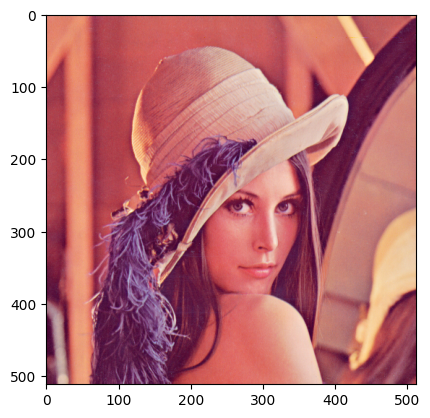

In [3]:
plt.imshow(img)

## Now let's make it grayscale
* 🔎 How many color channels did the original picture have? And how about grayscale?

In [4]:
rgb = np.array(img)
img = rgb2gray(rgb)
img = img/255.0
img.shape

(512, 512)

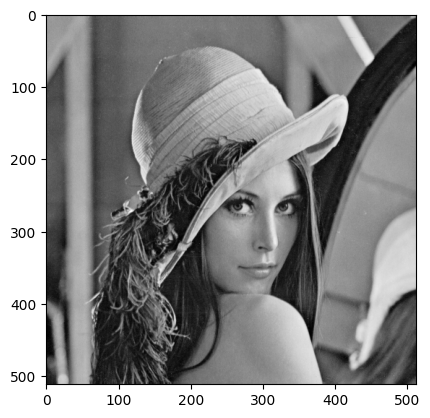

In [5]:
plt.imshow(img, cmap='gray')

## Now we can try some of the filters above

In [6]:
blur_mask = np.ones((3,3))/9.0
edge_mask = np.ones((3,3))*-1
edge_mask[1, 1] = 8
mask = np.array([
    [ 0,-1, 0],
    [-1, 4,-1],
    [ 0,-1, 0]
    ]) 

## We will start with bluring the image
* 🔎 What is the effect of the blur? 
    * What value does the uniform blur produce?
* 🔎 Why is blur often used in the image preprocessing?

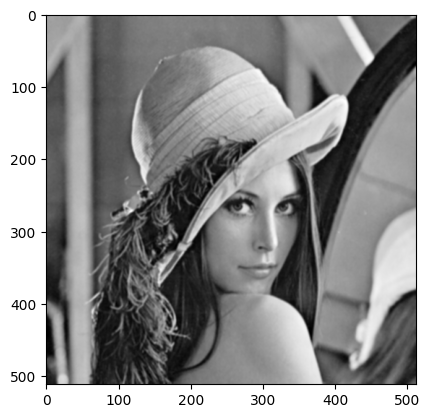

In [7]:
img_blur = convolve2d(img, blur_mask, boundary='symm', mode='same')
plt.imshow(img_blur, cmap='gray')

## Now we can apply another filter
* 🔎 Do you know what will the filter in the *edge_mask* variable do?
    * What is the effect of *np.clip()*?

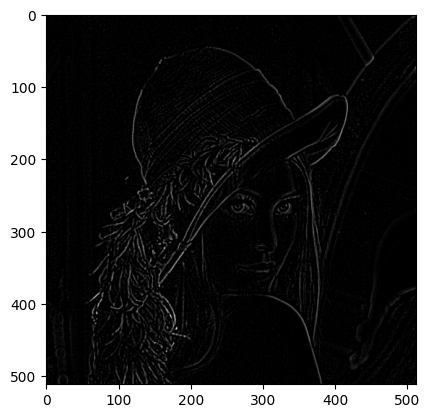

In [8]:
img_blur = convolve2d(img, blur_mask, boundary='symm', mode='same')
result = np.clip(convolve2d(img_blur, edge_mask, boundary='symm', mode='same'), 0, 1)
plt.imshow(result, cmap='gray')

## 📒 Pooling

Pooling is a way how to decrease the amount of information transfered from one layer to another.
The standard way ho to do it is Average Pooling and Maximum Pooling.

- Pooling results in (some) invariance to translation because shifting the image slightly does not change the activation map significantly. This property is referred to as translation invariance. 

- The idea is that similar images often have very different relative locations of the distinctive shapes within them, and translation invariance helps in being able to classify such images in a similar way. 
    - For example, one should be able to classify a bird as a bird, irrespective of where it occurs in the image.
    - Disadvantege is that you can for example succesfully classify image as face even though the position of eyes and mouth is switched, because model doesn't care about location of features in the image, their presence is for the model enough
    
- Avg. pooling is rarely used, usually we use max-pooling in the hidden layers, the only exception might be the last layer, where avg. pooling can significantly reduce the number of parameters.
- One alternative to using fully connected layers is to use average pooling across the whole spatial area of the final set of activation maps to create a single value. 
    - Therefore, the number of features created in the final spatial layer will be exactly equal to the number of filters. In this scenario, if the final activation maps are of size 7 × 7 × 256, then 256 features will be created. 
    - Each feature will be the result of aggregating 49 values. This type of approach greatly reduces the parameter footprint of the fully connected layers

![MaxPooling example](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/pooling_example.png?raw=true)

## ⚡ Understanding Layer Dimensions

### Convolution Effects 🔍
* Input: grayscale image (depth = 1)
* Conv2D with 32 filters:
  * ⬆️ Depth increases to 32
  * ↔️ Width/height may change based on padding

### Pooling Effects 🔄
* ⬇️ Reduces spatial dimensions
  * Width ÷ pooling size
  * Height ÷ pooling size
* 🔒 Depth remains unchanged

💡 Remember:
* Conv2D → More features (depth)
* Pooling → Smaller spatial dimensions

# Tensorflow implementation of the Convolution Neural Network is quite simple

### Utility functions
There are some functions we will use later several times
* `show_history` - show history plots of the **fit** method

* `show_example` - show 10x10 image grid with input image examples

* `display_activation` - CNN produces matrices as an each layer output, we can take a look at the output of the layers using this function


In [9]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

def show_example(train_x, train_y, class_names):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[train_y[i][0]])
    plt.show()
    
def display_activation(activations, col_size, row_size, act_index):
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            if activation_index < activation.shape[3]-1:
                activation_index += 1

## Load dataset
Import dataset **CIFAR10**
* The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. 
* The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. 
* There are 6,000 images of each class.

Dataset is then:
* splitted into train and test set,
* converted from the range <0,255> into <0, 1>,
* *train* is splitted into *train* and *validation* set,
* class names are defined.

In [10]:
# cifar is the basic dataset for image classifaction
dataset = tf.keras.datasets.cifar10

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

train_x = train_x/255.0
test_x = test_x/255.0

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# the data are in the form of 32x32 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Validation data shape: ', valid_x.shape, valid_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_count = len(class_names)
print('Class count:', class_count, class_names)


Train data shape:  (40000, 32, 32, 3) (40000, 1)
Validation data shape:  (10000, 32, 32, 3) (10000, 1)
Test data shape:   (10000, 32, 32, 3) (10000, 1)
Class count: 10 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## We will start with checking example images of the dataset first

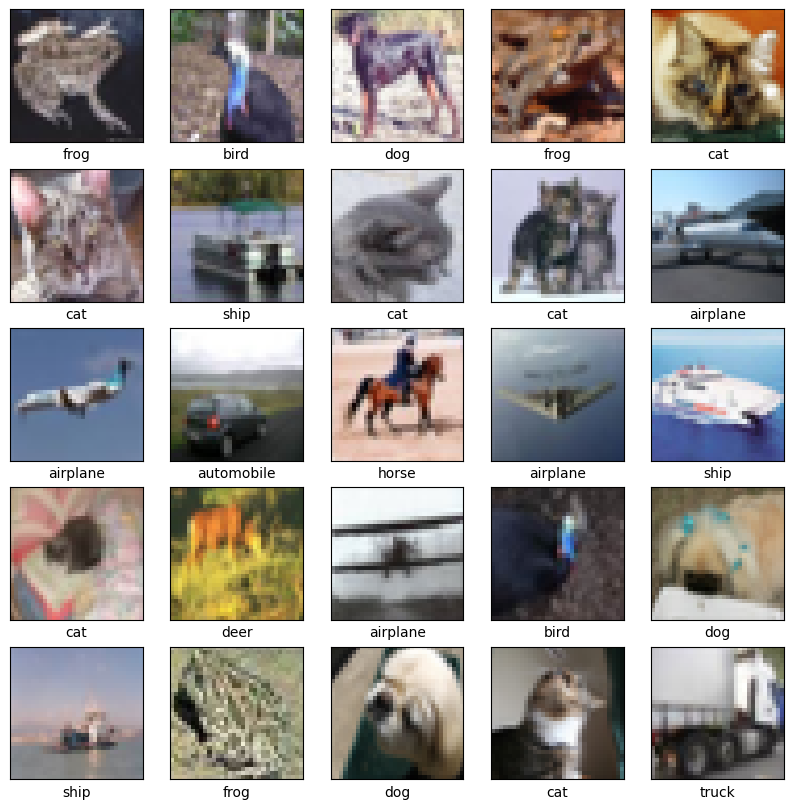

In [11]:
show_example(train_x, train_y, class_names)

# 🚀 Definition of the model
* The base model is defined as *Sequential* with just 2 convolutional layers.
* We will start with very simple model first, but we will make the model better later!

### Conv2D Layer Parameters 🔧
* filters: number of kernels
* kernel_size: filter dimensions
* activation: activation function
* padding: `valid` or `same`
* input_shape: for first layer only

### Dimension Questions ❓

1. For (32,32,3) input + `Conv2D(32)`:
   * Output depth = 32 (filter count)
   * WxH depends on padding
   * 'same' padding preserves dimensions

2. After `MaxPool2D(2,2)`:
   * Depth stays 32
   * Width ÷ 2
   * Height ÷ 2

### Why These Choices? 🤔
* Softmax: ❓
* Accuracy: ❓


In [12]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(16, (3,3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(class_count, activation='softmax')
])

model.summary()

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

/home/fei/svo0175/Documents/VSB-FEI-Deep-Learning-Exercises/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1739285012.582612  305148 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22181 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:02:00.0, compute capability: 8.9
I0000 00:00:1739285012.584055  305148 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22181 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:41:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       173,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,290 (700.35 KB)

 Trainable params: 179,290 (700.35 KB)

 Non-trainable params: 0 (0.00 B)

# Fit the model for defined number of epochs.
Show the history of learning, evaluate the efficiency of the model.

* 🔎 Did we overfit the model? What can we do about it if so?

In [13]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

Epoch 1/10


I0000 00:00:1739285014.825922  305491 service.cc:148] XLA service 0x7cf45c017c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739285014.825967  305491 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
I0000 00:00:1739285014.825972  305491 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-02-11 14:43:34.866799: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739285014.959088  305491 cuda_dnn.cc:529] Loaded cuDNN version 90300


  71/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1588 - loss: 2.2483

I0000 00:00:1739285015.957289  305491 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3627 - loss: 1.7485 - val_accuracy: 0.5229 - val_loss: 1.3301
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5590 - loss: 1.2572 - val_accuracy: 0.5773 - val_loss: 1.1849
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6157 - loss: 1.1004 - val_accuracy: 0.6171 - val_loss: 1.0976
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6460 - loss: 1.0070 - val_accuracy: 0.6422 - val_loss: 1.0320
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6785 - loss: 0.9310 - val_accuracy: 0.6535 - val_loss: 1.0076
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6973 - loss: 0.8651 - val_accuracy: 0.6545 - val_loss: 1.0023
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7141 - loss: 0.8152 - val_accuracy: 0.6395 - val_loss: 1.0552
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7377 - loss: 0.7527 - val_accurac

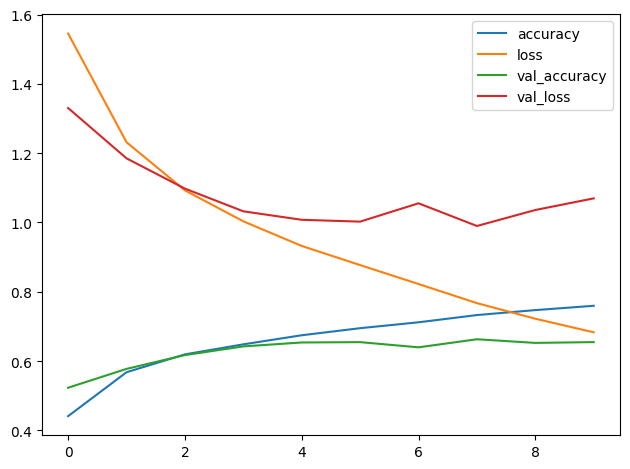

In [14]:
history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[model_checkpoint_callback], batch_size=32, epochs=10)

show_history(history)

# Load best setup
model.load_weights("best.weights.h5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

# 📊 Vizualization of the confusion matrix
* By definition a confusion matrix $C$ is such that $C_{i,j}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$
    * 🔎 How can we read such matrix?

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


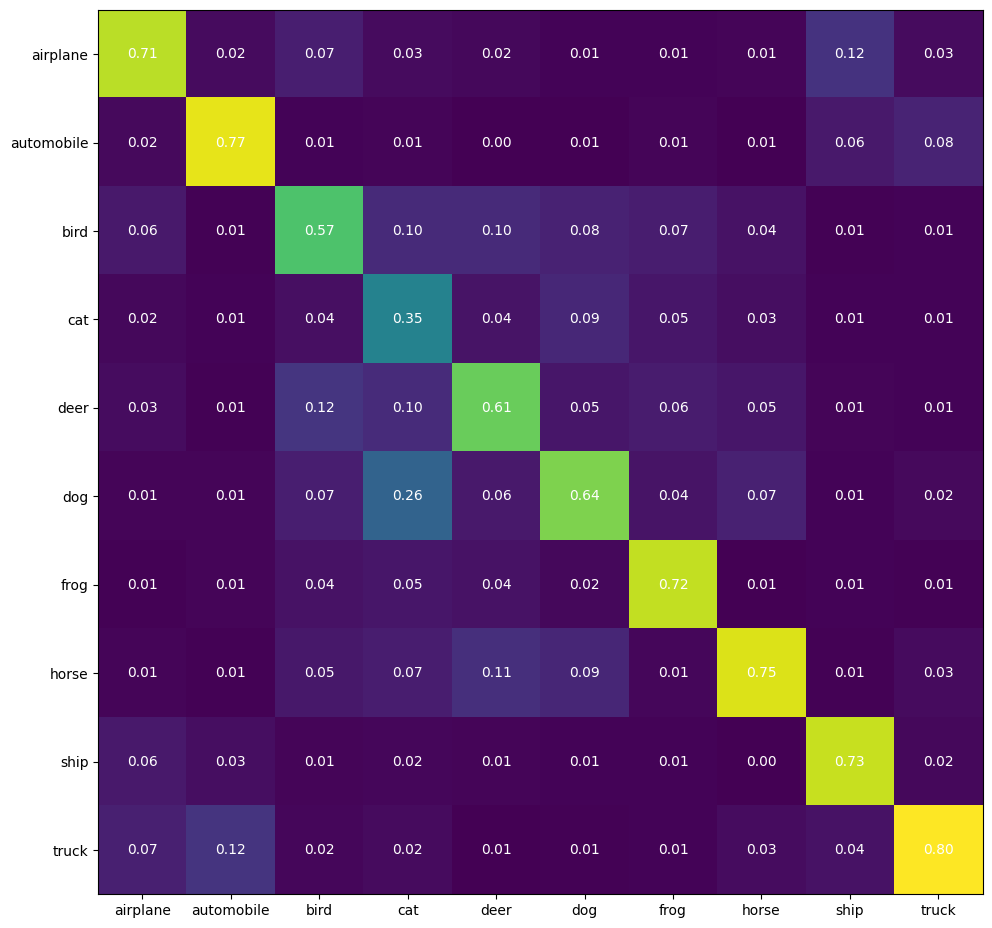

In [15]:
predictions = model.predict(test_x)

conf_matrix = confusion_matrix(np.argmax(predictions, axis=1), test_y.ravel(), normalize='pred')
plt.figure(figsize=(class_count,class_count))

plt.imshow(conf_matrix)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        text = plt.text(j, i, "{:.2f}".format(conf_matrix[i, j]), ha="center", va="center", color="w")

plt.xticks(range(class_count), class_names)
plt.yticks(range(class_count), class_names)

plt.tight_layout()
plt.show()     

# Visualize the layers
* Let's see what the network was able to learn from the train data. 
* For that, we need to prepare a new model and see the ouputs of the layers.

In [16]:
# Call the model with some input data to define the input shape
_ = model.predict(train_x[:1])

# Get the outputs form all layers in the model
layer_outputs = [layer.output for layer in model.layers]

# Create the model that has single input and as an output all the outputs from the layers. 
# Because the layers are connected then the output from first layer is propagated into second layer and the output is computed of it.
activation_model = keras.models.Model(inputs=model.inputs, outputs=layer_outputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


In [17]:
layer_outputs

[<KerasTensor shape=(None, 30, 30, 32), dtype=float32, sparse=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, 15, 15, 32), dtype=float32, sparse=False, name=keras_tensor_2>,
 <KerasTensor shape=(None, 13, 13, 16), dtype=float32, sparse=False, name=keras_tensor_3>,
 <KerasTensor shape=(None, 2704), dtype=float32, sparse=False, name=keras_tensor_4>,
 <KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_5>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_6>]

In [18]:
# get all the outputs from the model for 10-th input
activations = activation_model.predict(train_x[10].reshape((1, 32, 32, 3)))

/home/fei/svo0175/Documents/VSB-FEI-Deep-Learning-Exercises/venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


In [19]:
layer_outputs

[<KerasTensor shape=(None, 30, 30, 32), dtype=float32, sparse=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, 15, 15, 32), dtype=float32, sparse=False, name=keras_tensor_2>,
 <KerasTensor shape=(None, 13, 13, 16), dtype=float32, sparse=False, name=keras_tensor_3>,
 <KerasTensor shape=(None, 2704), dtype=float32, sparse=False, name=keras_tensor_4>,
 <KerasTensor shape=(None, 64), dtype=float32, sparse=False, name=keras_tensor_5>,
 <KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_6>]

## Input image

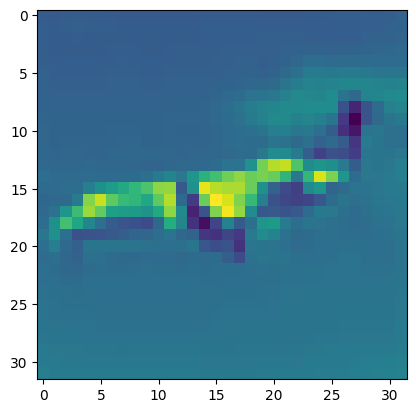

In [20]:
plt.imshow(train_x[10][:,:,0]);

## 🔎 Can you describe purpose of some layers based on the output?

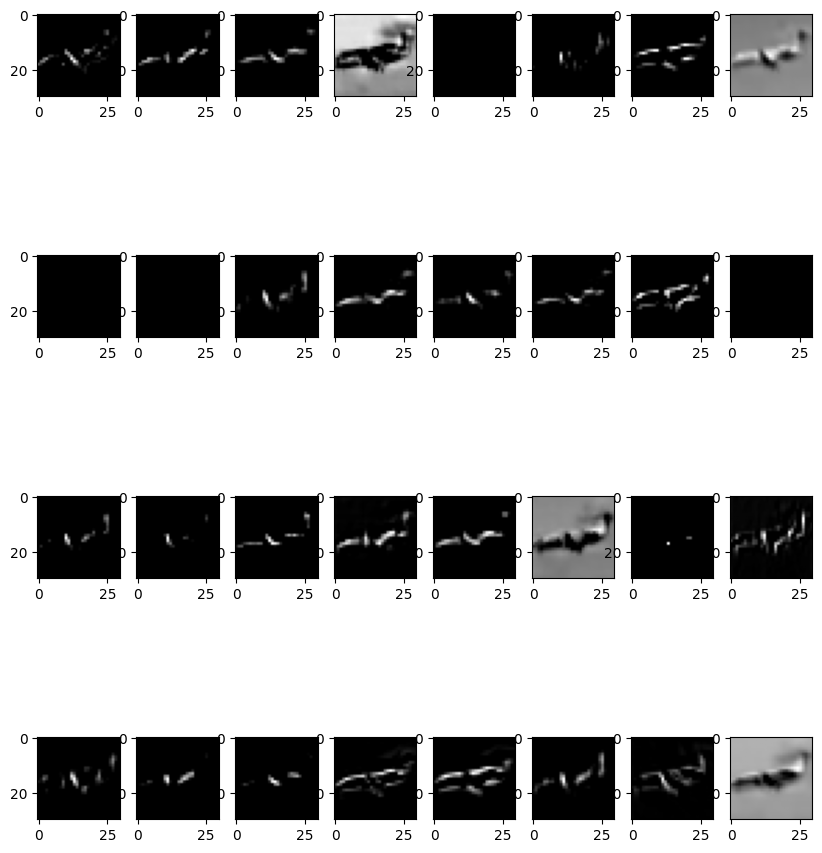

In [21]:
# show the output from the first layer - Conv2D
display_activation(activations, 8, 4, 0)

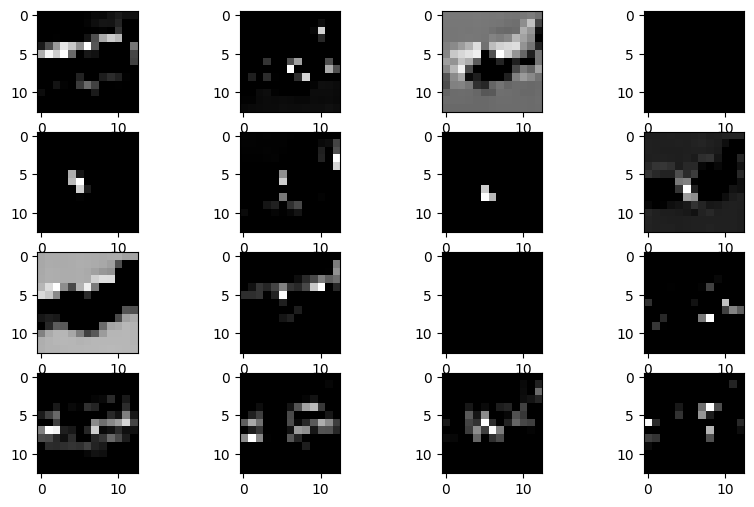

In [22]:
# show the second convolution layer
display_activation(activations, 4, 4, 2)

## 💡 You can see that the ANN just automated the manual image filter composition for the feature extraction used by traditional computer vision approaches

![Meme02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_02_meme.png?raw=true)

# 🔎 How to make ANN better?
* We can make out ANN better by architecture design changes or we can focus on detailts of the architecture such as activation functions or adding some helpful layers
    * e.g. Dropout, Batch. norm, ...

## 📒 Batch normalization
- If we have some two input variables with scales from 0 to 1 and from 0 to 1000 we can normalize them
    - Larger scale does not mean that the varible is more important than the other one
    - It's clear that without normalization one weight will be very high and other very low to balance the scale difference
    - This leads to slow gradient descent convergence - we need small learning rates
        - Loss function space is not smooth - gradients may oscillate back and forth before finding optimum
        
- This issue is present in hidden layers as well due to the mini-batch learning
    - Each batch is different from others from distributions point of view
    - Covariate shift effect - distribution of data is constantly changing during training
        - E.g. We train model on images of black cats - we learn how to map input X to output Y
        - If we now use images of colored cats for testing purposes the model will fail - input X changed thus learned mapping is invalid 
        - This shift happens internally with mini-batches all the time
        
- 📌 **Batch norm. standardize activation values to have same mean and variance among batch**
    - Slight regularization - it adds some noise to each hidden layer’s activations so less overfitting
    - We can use higher learning rates because batch normalization makes sure that there’s no activation that’s gone really high or really low
    - It makes the landscape of the corresponding optimization problem be significantly more smooth. This ensures, in particular, that the gradients are more predictive and thus allow for use of larger range of learning rates and faster network convergence
    
- 💡 Keras: tf.keras.layers.BatchNormalization
    - https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    - Usually after Conv or Dense layers
    - There are of course multiple different approaches where the batch norm. can be placed
 
## 📒 Activation function choice
* We can use any activation function we want, very common choice is ReLU or Leaky ReLU
* Another very popular activation function nowadays is **Mish (Self Regularized Non-Monotonic Activation Function)**
* It's not only one, there are more Swish etc.

* 🚀 Definitely checkout [Mish repo](https://github.com/digantamisra98/Mish)

In [23]:
class Mish(Activation):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X = Activation('Mish', name="conv1_act")(X_input)
    '''

    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'


def mish(inputs):
    return inputs * tf.math.tanh(tf.math.softplus(inputs))

get_custom_objects().update({'mish': Mish(mish)})

# ⚡ We can modify our network to use such tweaks very easily

### Activation Update 📈
* Replace ReLU with Mish
  * Smoother gradients
  * Better performance

### Overfitting Solutions 🛡️
* Add Dropout layers
* Use BatchNormalization
* Increase regularization
* Reduce model capacity

In [24]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='mish', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(16, (3,3), activation='mish'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(class_count, activation='softmax')
])

model.summary()

/home/fei/svo0175/Documents/VSB-FEI-Deep-Learning-Exercises/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2704)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       173,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,290 (700.35 KB)

 Trainable params: 179,290 (700.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3401 - loss: 1.8204 - val_accuracy: 0.5351 - val_loss: 1.3271
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5185 - loss: 1.3553 - val_accuracy: 0.5762 - val_loss: 1.2108
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5689 - loss: 1.2137 - val_accuracy: 0.5768 - val_loss: 1.2022
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6050 - loss: 1.1247 - val_accuracy: 0.6136 - val_loss: 1.0908
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6319 - loss: 1.0331 - val_accuracy: 0.6245 - val_loss: 1.0787
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6517 - loss: 0.9826 - val_accuracy: 0.6394 - val_loss: 1.0267
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6704 - loss: 0.9312 - val_accuracy: 0.6363 - val_loss: 1.0417
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6851 - loss: 0.8795 - 

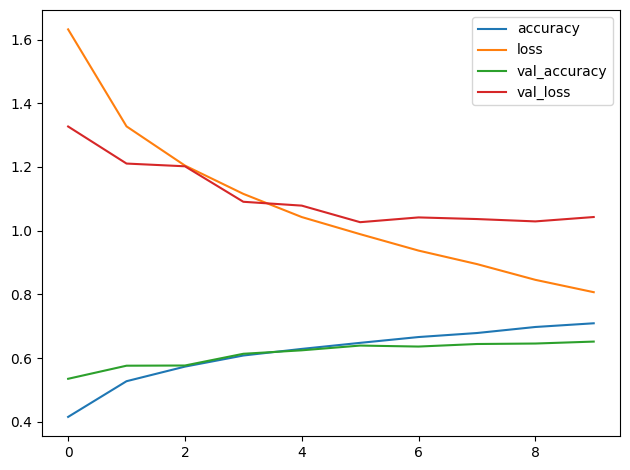

In [25]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[model_checkpoint_callback], batch_size=32, epochs=10)

show_history(history)

# Load best setup
model.load_weights("best.weights.h5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

## 🔎 Is the model better? What about the overfit?

## 🚀 Now we will add Batch normalization as well and try slight layer order change
* What will happen if we stack 2x Conv2D layers? 
* 🔎 Do we have more or less parameters than in the previous case?

In [26]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='mish', input_shape=(32, 32, 3)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(16, (3,3), activation='mish'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(class_count, activation='softmax')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,130 (809.10 KB)

 Trainable params: 207,034 (808.73 KB)

 Non-trainable params: 96 (384.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3655 - loss: 1.8541 - val_accuracy: 0.5431 - val_loss: 1.2989
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5484 - loss: 1.2837 - val_accuracy: 0.5864 - val_loss: 1.1516
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6121 - loss: 1.1070 - val_accuracy: 0.6130 - val_loss: 1.0996
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6454 - loss: 1.0003 - val_accuracy: 0.6486 - val_loss: 1.0108
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6715 - loss: 0.9318 - val_accuracy: 0.6579 - val_loss: 0.9877
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6881 - loss: 0.8863 - val_accuracy: 0.6272 - val_loss: 1.0783
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7095 - loss: 0.8206 - val_accuracy: 0.6388 - val_loss: 1.0658
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7293 - loss: 0.7723 - 

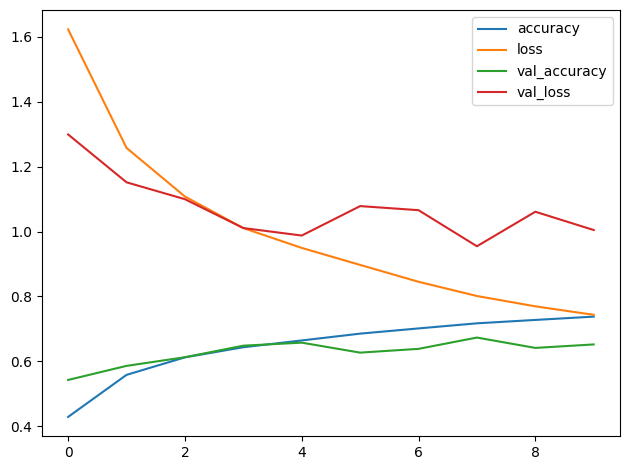

In [27]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[model_checkpoint_callback], batch_size=32, epochs=10)

show_history(history)

# Load best setup
model.load_weights("best.weights.h5")
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

![Data aug example](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/data_aug.png?raw=true)

## 📌 ANN models need huge amount of data as an input to function properly
### 💡 Data augmentation is very popular technique for the image data as it can help enlarge the dataset and harden the model for abnormal conditions

* ❌ There might be bug present in the TF2, so beware the label encoding
    * I had the same issue even few years ago, so I guess that today it's not a bug but a feature 😅
* 💡 We need to one-hot encode the labels and change the loss function to the CategoricalCrossentropy
    * Note that the output activation function is now set to softmax
    * Take a look at [this](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [28]:
# cifar is the basic dataset for image classifaction
dataset = tf.keras.datasets.cifar10

# data from any dataset are loaded using the load_Data function
(train_x, train_y), (test_x, test_y) = dataset.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_count = len(class_names)

train_y = tf.keras.utils.to_categorical(train_y, class_count)
test_y = tf.keras.utils.to_categorical(test_y, class_count)

train_x = train_x/255.0
test_x = test_x/255.0

# the data are in the form of 32x32 pixes with values 0-255.
print('Train data shape: ', train_x.shape, train_y.shape)
print('Test data shape:  ', test_x.shape, test_y.shape)
print('Class count:', class_count, class_names)


Train data shape:  (50000, 32, 32, 3) (50000, 10)
Test data shape:   (10000, 32, 32, 3) (10000, 10)
Class count: 10 ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## 📒 ImageDataGenerator provides variety of modifications
* 💡 You need to decide based on **the input data and task** that you try to solve which of the image modifications can be used given the real data obtained 💡
    * 📸 Imagine that you are designing a model for a **car detection used by the entry gate camera system** at the university parking lot entrance 
        * Your training dataset is made of images of cars, will the vertical flip (i.e. cars turned on the roof) of the images make any sense for your task?
    * 🚒 And what if the task is **traffic accident detection** in front of the car for autonomous driving system?
        * Can vertical flip help you now? 😊

In [29]:
datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)
datagen.fit(train_x)

epochs = 20

model = keras.Sequential([
    keras.layers.Conv2D(128, (5,5), activation='mish', input_shape=(32, 32, 3)),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (3,3), activation='mish', padding='same'),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64, (3,3), activation='mish'),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(class_count, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 710,986 (2.71 MB)

 Trainable params: 710,986 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/home/fei/svo0175/Documents/VSB-FEI-Deep-Learning-Exercises/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.3397 - loss: 1.8341 - val_accuracy: 0.4485 - val_loss: 1.6003
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5164 - loss: 1.3726 - val_accuracy: 0.5697 - val_loss: 1.2369
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5771 - loss: 1.2067 - val_accuracy: 0.6214 - val_loss: 1.0728
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6286 - loss: 1.0616 - val_accuracy: 0.6466 - val_loss: 1.0297
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6582 - loss: 0.9741 - val_accuracy: 0.6624 - val_loss: 0.9761
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6881 - loss: 0.8954 - val_accuracy: 0.6630 - val_loss: 1.0049
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7084 - loss: 0.8336 - val_accuracy: 0.6765 - val_loss: 0.9397
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7287 - loss: 0.7804 - val_accurac

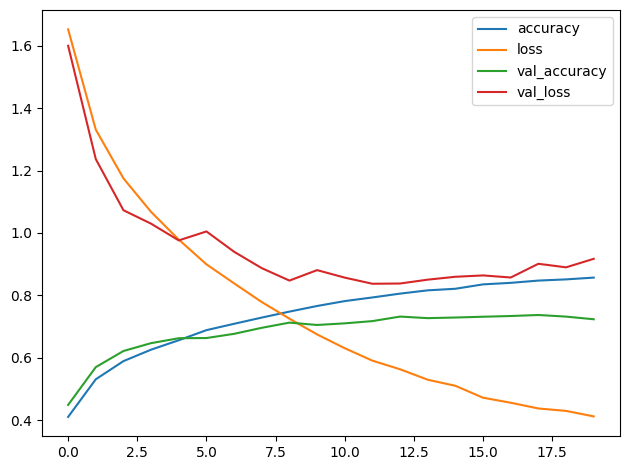

In [30]:
model.compile(
              loss=keras.losses.CategoricalCrossentropy(), 
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(datagen.flow(train_x, train_y,batch_size=32,
         subset='training'),  validation_data=datagen.flow(train_x, train_y,
         batch_size=32, subset='validation'), epochs=epochs)
show_history(history)

In [31]:
test_loss, test_acc = model.evaluate(test_x, test_y)
print('Test accuracy: ', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7345 - loss: 0.8906
Test accuracy:  0.7321000099182129


## 🚀 What if we have large datasets and we are not able to fit it into the memory?
* 💡 A very simple solution is to transform the dataset into the specific folder structure and use [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
    * We can leverage `tf.keras.preprocessing.image_dataset_from_directory` method for loading
* Let's try it with MNIST dataset

In [ ]:
 DATASET_NAME = 'mnist'
 OUTPUT_DIR = 'mnist_data'  # Directory to save the MNIST images
 TRAIN_DIR = os.path.join(OUTPUT_DIR, 'train')
 TEST_DIR = os.path.join(OUTPUT_DIR, 'test')

 # Create the output directories if they don't exist
 os.makedirs(TRAIN_DIR, exist_ok=True)
 os.makedirs(TEST_DIR, exist_ok=True)

In [37]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [46]:
def save_images(images, labels, directory, split_name):
    """Saves images from NumPy arrays to disk in a directory structure.

    Args:
        images: A NumPy array of images.
        labels: A NumPy array of corresponding labels.
        directory: The base directory to save the images to.
        split_name: "train" or "test", used for subdirectory creation.
    """

    split_dir = os.path.join(directory, split_name)  # e.g., mnist_data/train
    os.makedirs(split_dir, exist_ok=True)

    for i, (image, label) in tqdm(enumerate(zip(images, labels)), total=len(images)):
        label_dir = os.path.join(split_dir, str(label))  # e.g., mnist_data/train/5
        os.makedirs(label_dir, exist_ok=True)

        image = Image.fromarray(image)  # Convert NumPy array to PIL Image
        image_path = os.path.join(label_dir, f'{i:05d}.png')  # e.g., mnist_data/train/5/00001.png
        image.save(image_path)

    print(f"Finished saving {split_name} split.")

## Save the dataset in the directory

In [47]:
save_images(x_train, y_train, OUTPUT_DIR, 'train')
save_images(x_test, y_test, OUTPUT_DIR, 'test')

print("MNIST dataset saved to:", OUTPUT_DIR)

  0%|          | 0/60000 [00:00<?, ?it/s]

Finished saving train split.


  0%|          | 0/10000 [00:00<?, ?it/s]

Finished saving test split.
MNIST dataset saved to: mnist_data


## 🚀 Now we can load the dataset from the directory as a datastream

In [48]:
IMG_WIDTH, IMG_HEIGHT = 32, 32  # Adjust to the image size
BATCH_SIZE = 32

In [49]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',  # Assumes labels are based on directory structure
    label_mode='categorical',  # One-hot encode the labels
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    validation_split=0.2,  # 20% of the training data will be used for validation
    subset='training',  # This specifies that this is the training split
    seed=13  # For reproducibility
)

Found 60000 files belonging to 10 classes.
Using 48000 files for training.


In [50]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,  # Use the same training directory for validation data
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation',  # This specifies that this is the validation split
    seed=13
)

Found 60000 files belonging to 10 classes.
Using 12000 files for validation.


In [51]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 10 classes.


## Configure Dataset for higher performance
* `tf.data.AUTOTUNE` will dynamically determine the optimal buffer size at runtime, which can help improve the efficiency of data loading

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## ⚡ Build the CNN Model

In [56]:
num_classes = 10 

model = keras.Sequential([
    keras.layers.Rescaling(1./255, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),  # Normalize pixel values
    keras.layers.Conv2D(32, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')  # Output layer
])

model.summary()

/home/fei/svo0175/Documents/VSB-FEI-Deep-Learning-Exercises/venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best.weights.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

## 🚀 Finally, we will train the model and evaluate the performance

Epoch 1/10


2025-02-11 15:07:12.585842: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_268', 4 bytes spill stores, 4 bytes spill loads



1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9121 - loss: 0.2800 - val_accuracy: 0.9824 - val_loss: 0.0585
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9859 - loss: 0.0468 - val_accuracy: 0.9868 - val_loss: 0.0429
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9909 - loss: 0.0288 - val_accuracy: 0.9877 - val_loss: 0.0482
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9939 - loss: 0.0204 - val_accuracy: 0.9885 - val_loss: 0.0483
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9947 - loss: 0.0165 - val_accuracy: 0.9880 - val_loss: 0.0543
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9954 - loss: 0.0126 - val_accuracy: 0.9864 - val_loss: 0.0549
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9966 - loss: 0.0117 - val_accuracy: 0.9880 - val_loss: 0.0533
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9967 - loss: 0.0102 - val_accurac

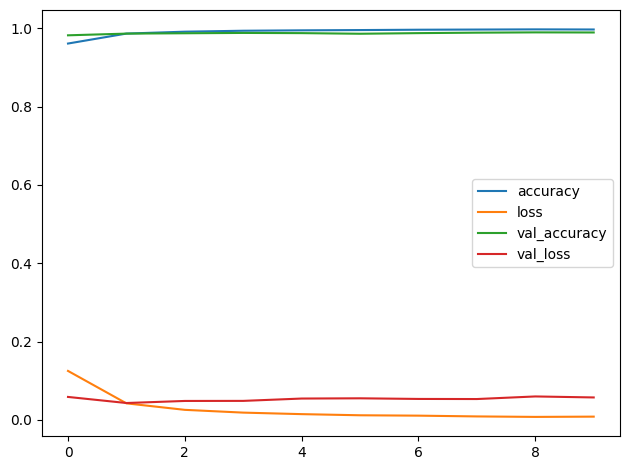

In [58]:
history = model.fit(train_dataset, validation_data=validation_dataset, callbacks=[model_checkpoint_callback], epochs=10)
show_history(history)

## 📊 Calculate the accuracy using the test data

In [60]:
model.load_weights("best.weights.h5")
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy: ', test_acc)

  1/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 1.0000 - loss: 0.0291

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9887 - loss: 0.0361
Test accuracy:  0.9861000180244446


# ✅  Tasks for the lecture (2p)
<!-- 1. [Data augmentation](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/) is used to expand the training dataset in order to improve the performance and ability of the model to generalize.
    - [Keras](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) -->
    
1) Design a model which will be able to classify **CIFAR10** with accuracy higher than **80% - (1p)**

    - 💡 Definitely train your model with more epochs than 10 (you can try 20 to 50 for example)

    - 💡 I recommend experimenting with the batch sizes, lower the batch size if the training is not stable (high variance in the loss function values) or higher the number if the training is too slow 
    
2) Try to work with MNIST and FashionMnist datasets as an image - **(1p)**

    - 99% on **Mnist** is achievable using CNN
    
    - 94% on **Fashion-Mnist**  (https://keras.io/api/datasets/fashion_mnist/) too 